# Bonus \#3: Decision Traces of Players

**

## Step 1: 

The first step to analyzing Empirica data is to export our data dump and move all our CSV files to a `data/` folder. The statement below executes the following four steps:

1. Exports the Empirica data dump into the current directory (will be stored as a .zip file)
2. Unzips the file to inflate 8 individual CSV files
3. Moves all the CSV files to a `data/` directory
4. Removes the original .zip file

In [1]:
! empirica export
! unzip *.zip
! mv *.csv data/
! rm *.zip

]11;?\Setting up export environment...
11:00:09.116 INF exporting data args="npm run export -- --filename /Users/shahabhishek1729/Documents/Projects/Empirica-Programming-Assignment/take-home-interview-producer-base/base_producer_experiment/default-experiment-2024-01-03-11-00-09.zip --tajfile /Users/shahabhishek1729/Documents/Projects/Empirica-Programming-Assignment/take-home-interview-producer-base/base_producer_experiment/.empirica/local/tajriba.json --srtoken uOSDVKOZdXiqbEkC"
]11;?\
> export@1.0.0 export
> npm run build && node --trace-warnings --enable-source-maps dist/index.js


> export@1.0.0 build
> esbuild src/index.js --platform=node --define:process.env.NODE_ENV='"production"' --bundle --minify --outfile=dist/index.js --sourcemap


  dist/index.js      1.5mb ⚠️
  dist/index.js.map  3.2mb

⚡ Done in 77ms

Exporting CSV to /Users/shahabhishek1729/Documents/Projects/Empirica-Programming-Assignment/take-home-interview-producer-base/base_producer_experiment/default-experiment-

## Step 2: Data preparation

The following code segments set up our imports and file paths, and load in our data.

When loading in data, we sort the game data by order of date to determine the most recent game played. We then only look at player data from that specific game.

In [2]:
import os, sys, gc
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
base_path = Path(".")
data_path = base_path / "demo_data"

games_path = data_path / "games.csv"
players_path = data_path / "players.csv"

# Make sure that all paths are valid
all_paths = [
    base_path,
    data_path,
    games_path,
    players_path,
]

for path in all_paths:
    assert path.exists()

In [4]:
def read_and_process_data() -> pd.DataFrame:
    players = pd.read_csv(players_path)

    # Get the ID of the most recent completed game
    games = pd.read_csv(games_path)
    games['statusLastChangedAt'] = pd.to_datetime(games.statusLastChangedAt)
    game_id = games \
        .sort_values(by="statusLastChangedAt", ascending=False)['id'] \
        .values[0]

    # Get the data from the latest game and remove all `LastChangesAt` columns which store modification
    # information and are not useful to us.
    curr_game_info = players[players.gameID == game_id].reset_index(drop=True)
    drop_cols = [c for c in curr_game_info.columns if c.endswith('LastChangedAt')]
    curr_game_info = curr_game_info.drop(drop_cols, axis = 1)

    # Explode our roundI_choices into 5 columns with each choice, for each I from 1 to 4, inclusive
    new_colnames = ["productionQ", "adQ", "sellP", "makeP", "warrantP"]

    for i in range(1, 5):
        choices = curr_game_info[f'round{i}_choices'].apply(lambda s: s[1:-1].split(','))
        colnames = [f"round{i}_{c}" for c in new_colnames]
        choices_df = pd.DataFrame(choices.to_list(), columns=colnames)
        curr_game_info = pd.concat((curr_game_info, choices_df), axis=1)

    curr_game_info = curr_game_info.drop([f'round{i}_choices' for i in range(1, 5)], axis=1)

    filter_colnames = ['productionQ', 'adQ', 'sellP', 'warrantP', 'salesCount']
    filter_cols = [f'round{i}_{colname}' for i in range(1, 5) for colname in filter_colnames]

    curr_game_choices = curr_game_info[['participantIdentifier'] + filter_cols]

    level2int = {
        "\"low\"": 1,
        "\"high\"": 2
    }

    for i in range(1, 5):
        curr_game_choices.loc[:, f'round{i}_productionQ'] = curr_game_choices[f'round{i}_productionQ'].map(level2int)
        curr_game_choices.loc[:, f'round{i}_adQ'] = curr_game_choices[f'round{i}_adQ'].map(level2int)    
        curr_game_choices[f'round{i}_sellP'] = curr_game_choices[f'round{i}_sellP'].astype(int)
        curr_game_choices[f'round{i}_warrantP'] = curr_game_choices[f'round{i}_warrantP'].astype(int)

    curr_game_choices = curr_game_choices.set_index('participantIdentifier', drop=True)

    return curr_game_choices

## Step 3: Tracking and Plotting User Choices

The following function uses the data processed earlier to plot a user's choices over time in each of the following quantities:

* Production quality (low or high)
* Advertised quality (low or high)
* Selling Price (\\$10 or \\$15)
* Warrant Price (no warrant or \\$1,000)

This function takes in the following parameters:
* `value_col`: The column in the original data to track (one of either `productionQ`, `adQ`, `sellP`, or `warrantP`, in the order described above)
* `value_name`: The label to use to title the graph (e.g., "Production quality" for `productionQ`)
* `y_tick_vals`: The tick values to draw on the Y-axis in the plot. Unless specified, `[1, 2]` will be used
* `y_tick_labels`: The labels to add to the tick values on the Y-axis in the plot. Unless specified, `["low", "high"]`, and draws their respective plots

In [5]:
curr_game_choices = read_and_process_data()

players = list(curr_game_choices.index.values)

def track_and_plot(value_col: str, /, value_name: str, *, 
                   y_tick_vals: list[int] = [1, 2], 
                   y_tick_labels: list[str] = ["Low", "High"]):
    values = []

    for p in players:
        values.append([curr_game_choices.loc[p,][f'round{i}_{value_col}'] for i in range(1, 5)])

    data = dict(zip(players, values))
    
    width = 0.25
    multiplier = 0
    
    fig, ax = plt.subplots(layout='constrained')

    for i, p in enumerate(players):
        # 0.4i - 0.2 is a basic function to map 0 to -0.2 and 1 to +0.2, which allows us to offset our paired bars
        ax.bar(np.array(range(4)) + width*multiplier, data[p], 0.8/len(players), label=p)
        multiplier += 1

    plt.xticks([0, 1, 2, 3], ["Round 1", "Round 2", "Round 3", "Round 4"])
    plt.yticks(y_tick_vals, y_tick_labels)

    plt.title(f"{value_name.capitalize()} through each round")

    plt.legend()
    plt.show()

### Examples

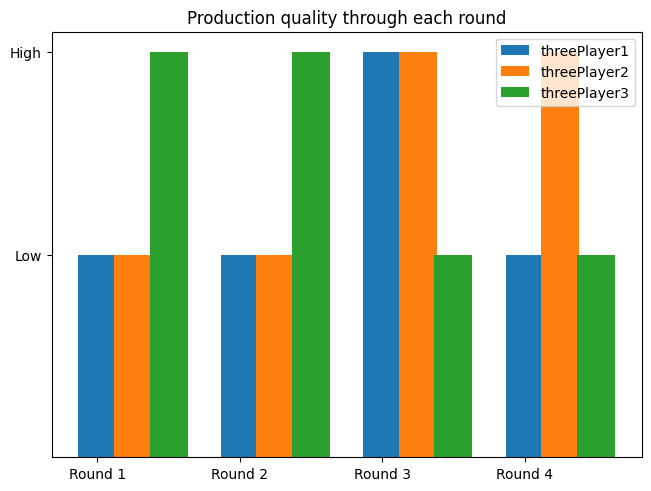

In [6]:
# Plotting all users' production quality decisions over time
track_and_plot("productionQ", value_name = "production quality")

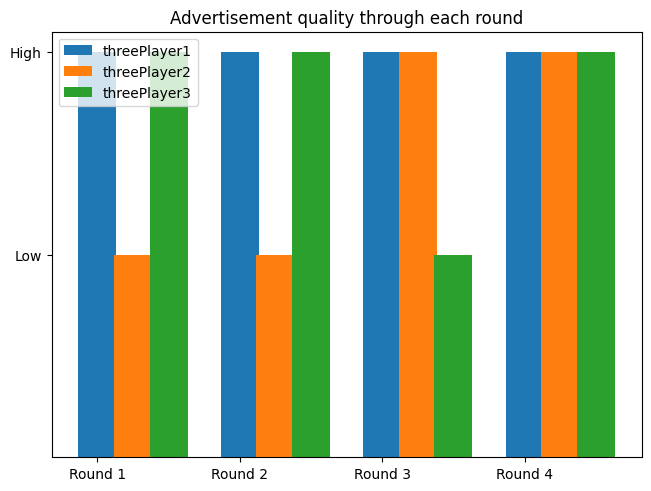

In [7]:
# Plotting all users' advertised quality decisions over time
track_and_plot("adQ", value_name = "advertisement quality")

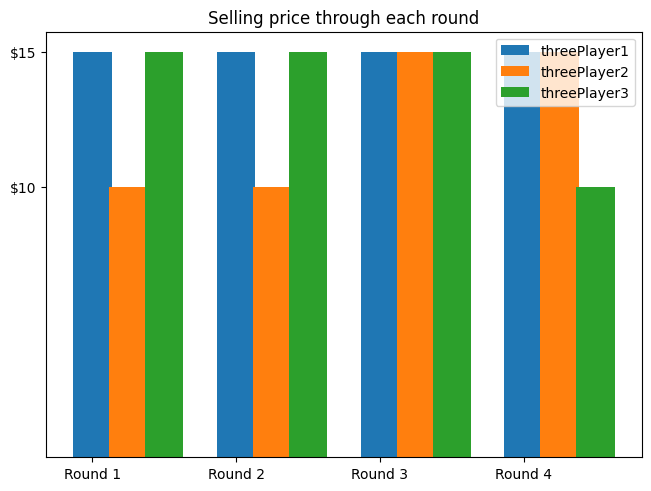

In [8]:
# Plotting all users' selling price decisions over time
track_and_plot("sellP", value_name = "selling price", y_tick_vals = [10, 15], y_tick_labels = ["$10", "$15"])

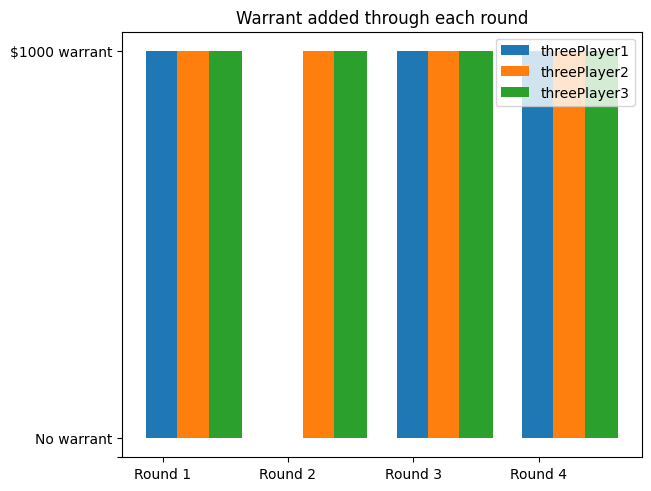

In [9]:
# Plotting all users' selling price decisions over time
track_and_plot("warrantP", value_name = "warrant added", y_tick_vals = [-50, 0, 1000], y_tick_labels = ["", "No warrant", "$1000 warrant"])

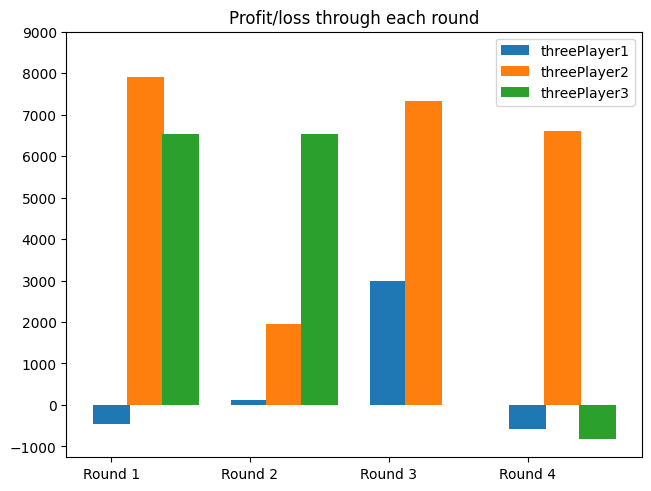

In [10]:
# Plotting all users' scores through each round
track_and_plot("salesCount", value_name = "profit/loss", y_tick_vals=range(-1_000, 10_000, 1_000), y_tick_labels=None)

In [11]:
curr_game_choices

,round1_productionQ,round1_adQ,round1_sellP,round1_warrantP,round1_salesCount,round2_productionQ,round2_adQ,round2_sellP,round2_warrantP,round2_salesCount,round3_productionQ,round3_adQ,round3_sellP,round3_warrantP,round3_salesCount,round4_productionQ,round4_adQ,round4_sellP,round4_warrantP,round4_salesCount
participantIdentifier,,,,,,,,,,,,,,,,,,,,
threePlayer1,1,2,15,1000,-470,1,2,15,0,130.0,2,2,15,1000,2978.0,1,2,15,1000,-580.0
threePlayer2,1,1,10,1000,7905,1,1,10,1000,1955.0,2,2,15,1000,7340.0,2,2,15,1000,6614.0
threePlayer3,2,2,15,1000,6542,2,2,15,1000,6524.0,1,1,15,1000,-10.0,1,2,10,1000,-825.0


### Conclusions

As the above plots show, player 1 began this game by attempting to make low-quality products and advertise them as high-quality at a price of $15. Although they first attempted to warrant this ad, their losses led them to attempt the same production-advertised quality combination, except this time without a warrant. Still, they ended up making significantly less than their competitors. Later, the adapted an honest approach in round 3, with significantly more success. Player 3 had a similar story, beginning honestly with success, but later succumbing to greed and suffering losses in rounds 3 and 4. Player 2 stayed honest throughout, and ended the game as the clear winner.